In [24]:
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import tensorflow as tf
import os
import pandas as pd
from datetime import datetime, timedelta

In [25]:
# -------------------- Load GPU Delegate --------------------
delegate = None
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    from tensorflow import lite as tflite

try:
    delegate = tf.lite.experimental.load_delegate("libtensorflowlite_gpu_delegate.so")
    print("GPU delegate loaded successfully.")
except Exception as e:
    print("GPU delegate not available:", e)

# -------------------- Patch Interpreter BEFORE importing wrapper --------------------
if not hasattr(tflite, "_original_interpreter"):
    tflite._original_interpreter = tflite.Interpreter

    def Interpreter_with_delegate(*args, **kwargs):
        if delegate is not None:
            kwargs["experimental_delegates"] = [delegate]
        return tflite._original_interpreter(*args, **kwargs)

    tflite.Interpreter = Interpreter_with_delegate

Exception ignored in: <function Delegate.__del__ at 0x000001FECE2FEFC0>
Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\envs\an\Lib\site-packages\tensorflow\lite\python\interpreter.py", line 121, in __del__
    if self._library is not None:
       ^^^^^^^^^^^^^
AttributeError: 'Delegate' object has no attribute '_library'


GPU delegate not available: Could not find module 'libtensorflowlite_gpu_delegate.so' (or one of its dependencies). Try using the full path with constructor syntax.


In [132]:
T = 24 #Cyclicity of our data
data = pd.read_csv(r"C:\Users\DELL\Desktop\Sanjay_Van_Monitoring\Origin Spot\17052025-29062025_30R30W\result.csv")

In [133]:
# #Temp
# data["Month"] = data["Filename"].str[15:17].astype(int)
# data["Year"] = data["Filename"].str[11:15].astype(int)
# data.rename(columns={"date":"Date"}, inplace=True)
data["Second"]=(data["Segment"]-1)*180
data

,Filename,Segment,Month,Date,Hour,Minute,ADI,ACI,AEI,NDSI,Second
0,04213SPOT1_20250517_080110.wav,1,5,17,8,1,1.758587,0.702422,0.718188,-0.789106,0
1,04213SPOT1_20250517_080110.wav,2,5,17,8,1,2.737565,0.248629,0.561307,-0.874851,180
2,04213SPOT1_20250517_080110.wav,3,5,17,8,1,3.113761,0.152315,0.501022,-0.630063,360
3,04213SPOT1_20250517_080110.wav,4,5,17,8,1,2.899839,0.171832,0.535303,-0.927161,540
4,04213SPOT1_20250517_080110.wav,5,5,17,8,1,2.811762,0.204938,0.549417,-0.408429,720
...,...,...,...,...,...,...,...,...,...,...,...
2865,04213SPOT1_20250529_060000.wav,6,5,29,6,0,2.851465,0.162068,0.543055,-0.959193,900
2866,04213SPOT1_20250529_060000.wav,7,5,29,6,0,3.220818,0.212602,0.483866,-0.870753,1080
2867,04213SPOT1_20250529_060000.wav,8,5,29,6,0,3.471316,0.160437,0.443724,-0.468431,1260
2868,04213SPOT1_20250529_060000.wav,9,5,29,6,0,3.250243,0.226457,0.479151,-0.248272,1440


In [134]:
# Compute difference in hours between two time stamps.


def safe_datetime(year, month, day, hour, minute, second):
    #ensures the validity of time stamps
    # Construct base datetime at 00:00:00
    base = datetime(year, month, day)
    # Add time using timedelta (handles overflow correctly)
    return base + timedelta(hours=hour, minutes=minute, seconds=second)

def time_difference_in_hours(end, start):
    start_dt = safe_datetime(*start)
    end_dt   = safe_datetime(*end)
    delta = end_dt - start_dt
    return delta.total_seconds() / 3600.0

def harmonic_features(t, T, K):
    #computes the harmonic features
    X = [np.ones(len(t))]  # Intercept
    for k in range(1, K+1):
        X.append(np.cos(2 * np.pi * k * t / T))
        X.append(np.sin(2 * np.pi * k * t / T))
    return np.column_stack(X)



In [136]:

# ----------------- Day-wise Harmonic Regression -----------------
# This section performs harmonic regression for each day in the dataset.


#main execution
indices = ['ADI', 'ACI', 'AEI', 'NDSI']

#iterating over the dataset
for i in range(len(data)):
    start_year = data.loc[data["Date"]==data["Date"][i]]["Year"].iloc[0].item()
    start_hour = data.loc[data["Date"]==data["Date"][i]]["Hour"].iloc[0].item()
    start_minute = data.loc[data["Date"]==data["Date"][i]]["Minute"].iloc[0].item()
    start_second = data.loc[data["Date"]==data["Date"][i]]["Second"].iloc[0].item()
    start_month = data.loc[data["Date"]==data["Date"][i]]["Month"].iloc[0].item()
    start_day = data.loc[data["Date"]==data["Date"][i]]["Date"].iloc[0].item()
    start=(start_year, start_month, start_day, start_hour, start_minute, start_second)

    # end_year = data["Year"][i].item()
    end_hour = data["Hour"][i].item()
    end_minute = data["Minute"][i].item()
    end_second = data["Second"][i].item()
    end_month = data["Month"][i].item()
    end_day = data["Date"][i].item()
    end = (end_year, end_month, end_day, end_hour, end_minute, end_second)
    data.loc[i, "t"] = time_difference_in_hours(end, start)

data
K = 3  # Number of harmonics
models=[]
for date in data["Date"].unique():
    X = harmonic_features(data.loc[data["Date"]==date, "t"], T, K)
# Fit the models
    temp={"date":date}
    for indice in indices:
        model = LinearRegression().fit(X, data.loc[data["Date"]==date, indice])
        temp[indice] = model
    models.append(temp)


KeyError: 'Year'

In [125]:
# coefficients for day wise harmonic regression
# This section extracts the coefficients from the fitted models for each day.
coefficients1 = []
for indices in models:
    temp2 = {}
    temp2["date"] = indices["date"]
    for indice, model in indices.items():
        if indice == "date":
            continue
        temp2[indice] = {
            "Intercept": model.intercept_,
            "Coefficients": model.coef_
        }
    coefficients1.append(temp2)


coefficients1

[{'date': np.int64(2),
  'ADI': {'Intercept': np.float64(5.155195436826011),
   'Coefficients': array([ 0.        ,  1.05595314, -2.6000689 , -1.66137488, -0.71740157,
          -0.61788758,  0.72135273])},
  'ACI': {'Intercept': np.float64(0.3140822109931199),
   'Coefficients': array([ 0.        ,  0.06093   , -0.1351    , -0.07309352, -0.05014638,
          -0.03250462,  0.03328564])},
  'AEI': {'Intercept': np.float64(0.173883407635398),
   'Coefficients': array([ 0.        , -0.16921578,  0.41665928,  0.2662342 ,  0.11496312,
           0.09901607, -0.11559629])},
  'NDSI': {'Intercept': np.float64(0.08188975884299937),
   'Coefficients': array([ 0.        ,  0.38570005, -0.95786682, -0.7903939 , -0.17213308,
          -0.30918181,  0.41761696])}},
 {'date': np.int64(3),
  'ADI': {'Intercept': np.float64(3.84558897375),
   'Coefficients': array([ 0.        , -0.16556837,  0.22466275, -0.06832796,  0.13517297,
          -0.11979917,  0.10370638])},
  'ACI': {'Intercept': np.float64

In [137]:

#  -------------------- For week-wise harmonic regression -----------------
# This section performs harmonic regression for the first week and the rest of the data.
median_data=[]
for date in data["Date"].unique():
    for hour in data.loc[data["Date"]==date, "Hour"].unique():
        median_data.append(data.loc[(data["Date"]==date) & (data["Hour"]==hour)].iloc[0].copy())
        for indice in indices:
            median_data[-1][indice] = data.loc[(data["Date"]==date) & (data["Hour"]==hour)][indice].median()
median_data = pd.DataFrame(median_data).reset_index(drop=True)
data1 = median_data.loc[(median_data["Date"][0]<=median_data["Date"]) & (median_data["Date"]<=median_data["Date"][0]+6)].reset_index(drop=True)
data2 = median_data.loc[median_data["Date"]>median_data["Date"][0]+6].reset_index(drop=True)

In [138]:
data2

,Filename,Segment,Month,Date,Hour,Minute,ADI,ACI,AEI,NDSI,Second
0,04213SPOT1_20250524_000000.wav,1,5,24,0,0,3.230005,0.123032,0.482394,-0.499975,0
1,04213SPOT1_20250524_010000.wav,1,5,24,1,0,3.937372,0.111756,0.369039,-0.291627,0
2,04213SPOT1_20250524_020000.wav,1,5,24,2,0,4.658591,0.123623,0.253464,-0.253307,0
3,04213SPOT1_20250524_030000.wav,1,5,24,3,0,4.559001,0.099141,0.269423,-0.450621,0
4,04213SPOT1_20250524_040000.wav,1,5,24,4,0,4.699752,0.092218,0.246868,-0.349980,0
...,...,...,...,...,...,...,...,...,...,...,...
122,04213SPOT1_20250529_020000.wav,1,5,29,2,0,3.706741,0.146956,0.405997,-0.739940,0
123,04213SPOT1_20250529_030000.wav,1,5,29,3,0,4.273679,0.118407,0.315146,-0.406370,0
124,04213SPOT1_20250529_040000.wav,1,5,29,4,0,4.680999,0.106122,0.249873,-0.363735,0
125,04213SPOT1_20250529_050000.wav,1,5,29,5,0,3.401985,0.256723,0.454834,-0.027815,0


In [140]:
#1st week
indices = ['ADI', 'ACI', 'AEI', 'NDSI']

# start_year = data1["Year"][0].item()
start_hour = data1["Hour"][0].item()
start_minute = data1["Minute"][0].item()
start_second = data1["Second"][0].item()
start_month = data1["Month"][0].item()
start_day = data1["Date"][0].item()
start=(start_year, start_month, start_day, start_hour, start_minute, start_second)

for i in range(len(data1)):
    # end_year = data1["Year"][i].item()
    end_hour = data1["Hour"][i].item()
    end_minute = data1["Minute"][i].item()
    end_second = data1["Second"][i].item()
    end_month = data1["Month"][i].item()
    end_day = data1["Date"][i].item()
    end = (end_year, end_month, end_day, end_hour, end_minute, end_second)
    data1.loc[i, "t"] = time_difference_in_hours(end, start)

K = 3  # Number of harmonics
X = harmonic_features(data1["t"], T, K)
# Fit the models
models1={"Series":1}
for indice in indices:
    model = LinearRegression().fit(X, data1[indice])
    models1[indice] = model


In [120]:
#2nd week
indices = ['ADI', 'ACI', 'AEI', 'NDSI']

start_year = data2["Year"][0].item()
start_hour = data2["Hour"][0].item()
start_minute = data2["Minute"][0].item()
start_second = data2["Second"][0].item()
start_month = data2["Month"][0].item()
start_day = data2["Date"][0].item()
start=(start_year, start_month, start_day, start_hour, start_minute, start_second)

for i in range(len(data2)):
    end_year = data2["Year"][i].item()
    end_hour = data2["Hour"][i].item()
    end_minute = data2["Minute"][i].item()
    end_second = data2["Second"][i].item()
    end_month = data2["Month"][i].item()
    end_day = data2["Date"][i].item()
    end = (end_year, end_month, end_day, end_hour, end_minute, end_second)
    data2.loc[i, "t"] = time_difference_in_hours(end, start)

K = 3  # Number of harmonics
X = harmonic_features(data2["t"], T, K)
# Fit the models
models2={"Series":1}
for indice in indices:
    model = LinearRegression().fit(X, data2[indice])
    models2[indice] = model

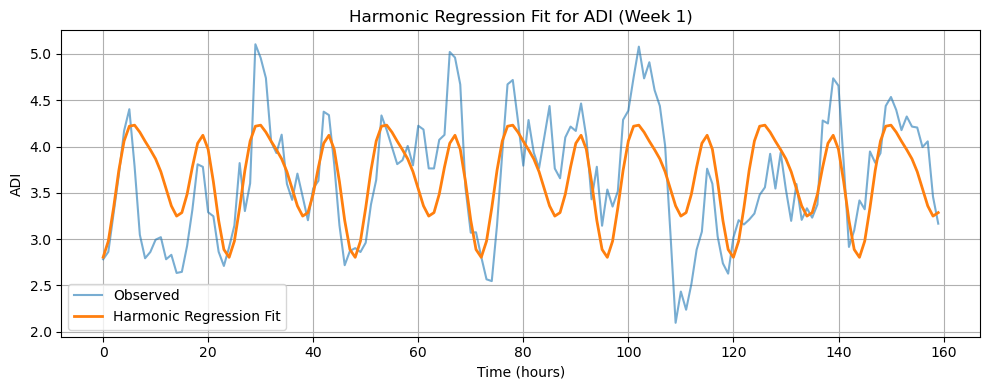

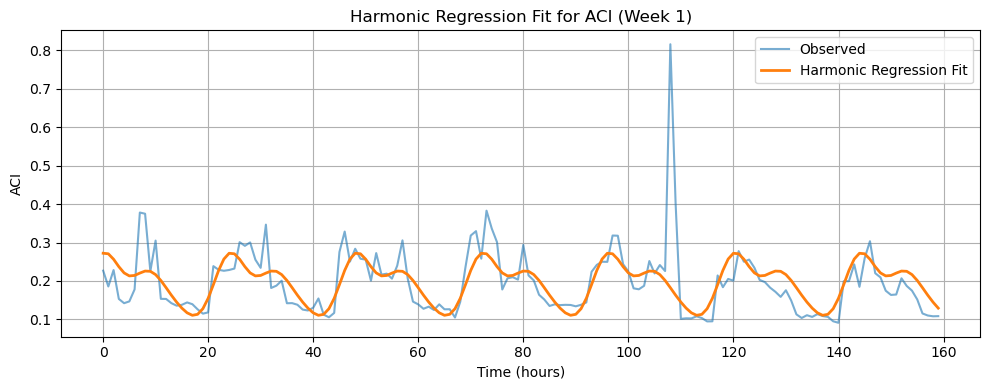

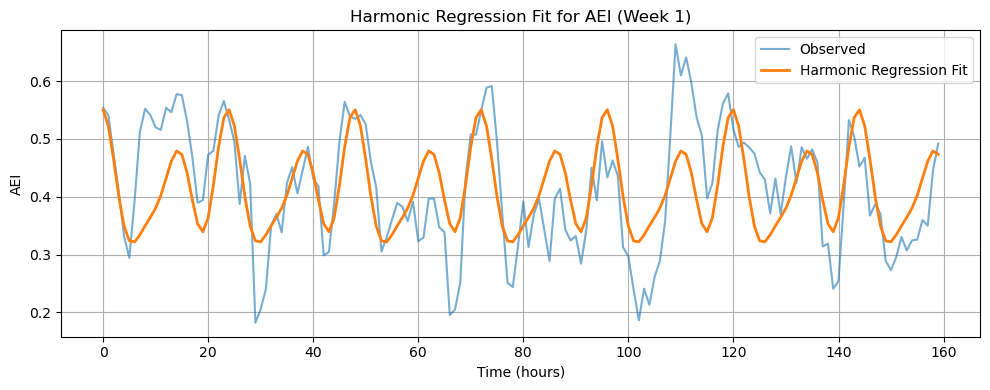

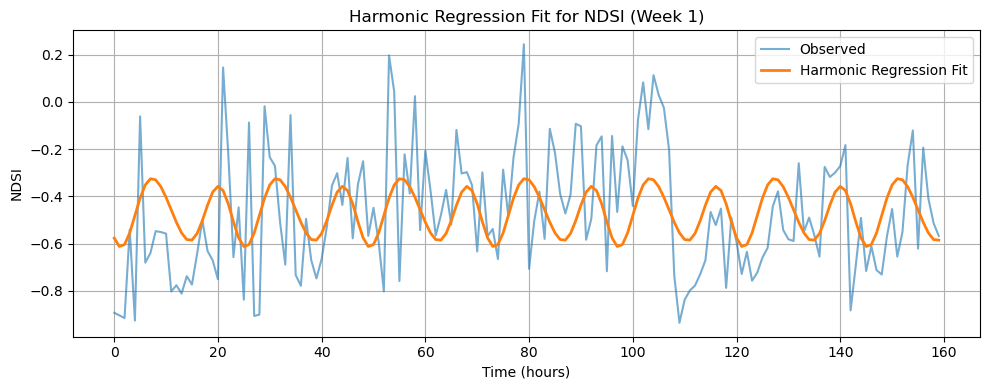


Harmonic Regression Coefficients:
  Index  Intercept  coef_1    coef_2    coef_3    coef_4    coef_5    coef_6  \
0   ADI   3.654165     0.0 -0.165135  0.191344 -0.480376 -0.135185 -0.203659   
1   ACI   0.195500     0.0  0.035550  0.050314  0.031626 -0.012527  0.009456   
2   AEI   0.414423     0.0  0.026463 -0.030663  0.076980  0.021663  0.032636   
3  NDSI  -0.468459     0.0 -0.013965  0.029779 -0.074976 -0.100825 -0.019106   

     coef_7  
0  0.095356  
1 -0.000200  
2 -0.015281  
3 -0.013021  


In [141]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Assume you already have:
# - data1["t"] computed (time in hours)
# - harmonic_features(t, T, K) defined
# - T is the total cycle period (e.g. 24 for diurnal)

indices = ['ADI', 'ACI', 'AEI', 'NDSI']
K = 3  # Number of harmonics
T = 24  # Example: 24-hour cycle

X = harmonic_features(data1["t"], T, K)

# Store models and coefficients
models1 = {"Series": 1}
coef_df_1 = pd.DataFrame(columns=["Index", "Intercept"] + [f"coef_{i+1}" for i in range(X.shape[1])])

# Fit and record models
for indice in indices:
    model = LinearRegression().fit(X, data1[indice])
    models1[indice] = model

    # Save coefficients
    row = [indice, model.intercept_] + model.coef_.tolist()
    coef_df_1.loc[len(coef_df_1)] = row

# --- Plotting ---
for i in range(len(indices)):
    y_pred = models1[indices[i]].predict(X)
    plt.figure(figsize=(10, 4))
    plt.plot(data1["t"], data1[indices[i]], label='Observed', alpha=0.6)
    plt.plot(data1["t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
    plt.legend()
    plt.title(f"Harmonic Regression Fit for {indices[i]} (Week 1)")
    plt.xlabel("Time (hours)")
    plt.ylabel(indices[i])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Show or save coefficients ---
print("\nHarmonic Regression Coefficients:")
print(coef_df_1)

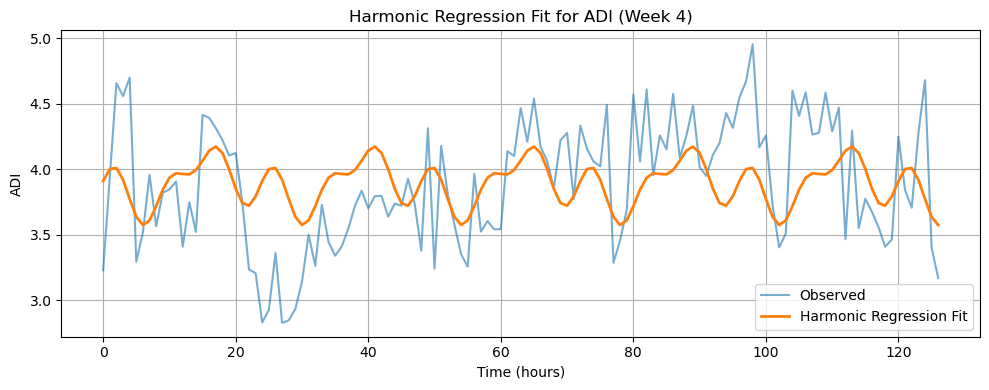

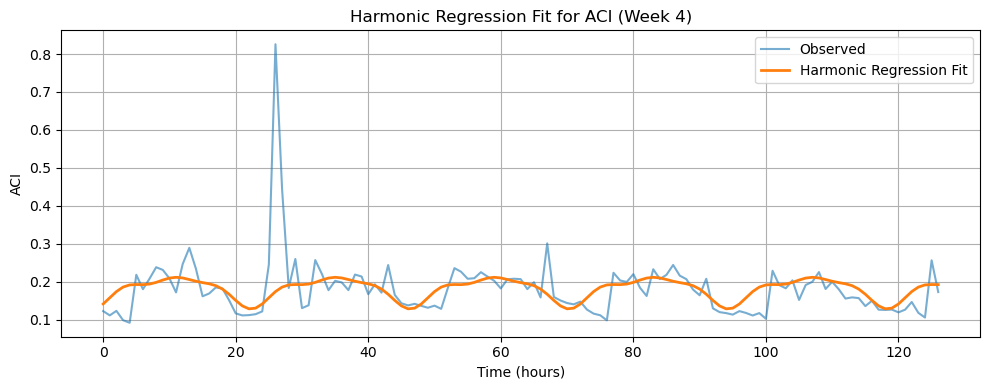

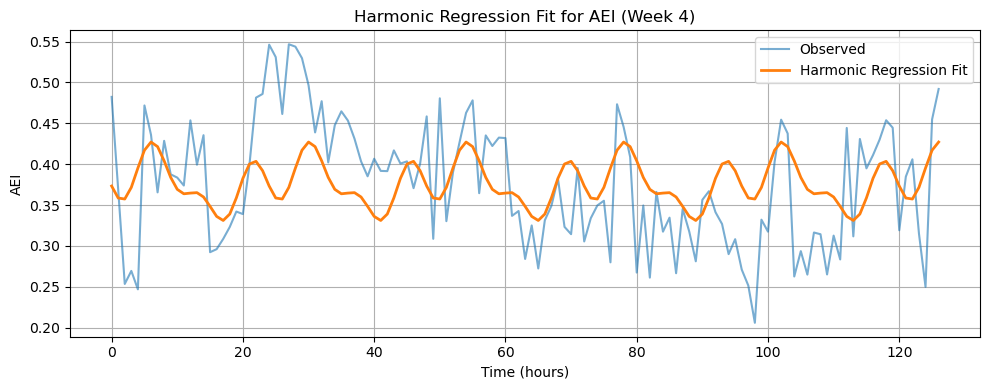

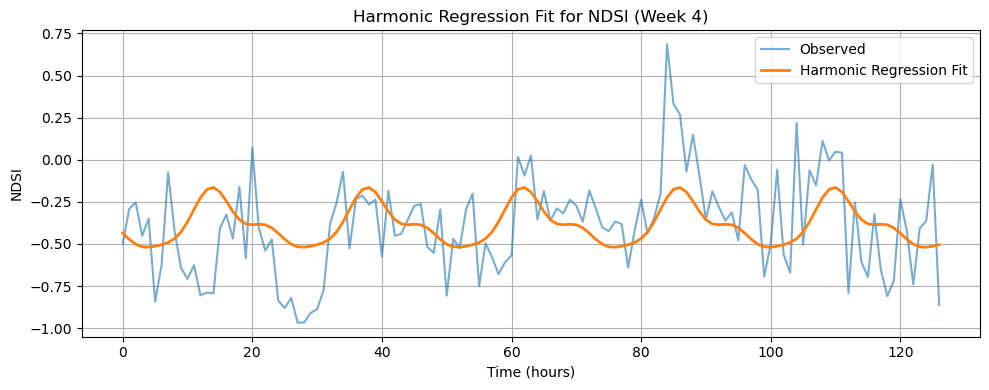


Harmonic Regression Coefficients:
  Index  Intercept  coef_1    coef_2    coef_3    coef_4    coef_5    coef_6  \
0   ADI   3.893760     0.0 -0.145059 -0.057246  0.099880  0.043991  0.129903   
1   ACI   0.181457     0.0  0.012856 -0.031238  0.010697 -0.005415  0.007036   
2   AEI   0.376028     0.0  0.023246  0.009174 -0.016006 -0.007050 -0.020817   
3  NDSI  -0.379889     0.0 -0.102693 -0.102290  0.025697  0.049826 -0.028449   

     coef_7  
0  0.030307  
1 -0.003022  
2 -0.004857  
3 -0.003553  


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Step 1: Time origin
indices = ['ADI', 'ACI', 'AEI', 'NDSI']

#start_year = data2["Year"][0].item()
start_hour = data2["Hour"][0].item()
start_minute = data2["Minute"][0].item()
start_second = data2["Second"][0].item()
start_month = data2["Month"][0].item()
start_day = data2["Date"][0].item()
start = (start_year, start_month, start_day, start_hour, start_minute, start_second)

# Step 2: Compute time difference in hours
def time_difference_in_hours(end, start):
    import datetime
    t1 = datetime.datetime(*start)
    t2 = datetime.datetime(*end)
    return (t2 - t1).total_seconds() / 3600

for i in range(len(data2)):
    #end_year = data2["Year"][i].item()
    end_hour = data2["Hour"][i].item()
    end_minute = data2["Minute"][i].item()
    end_second = data2["Second"][i].item()
    end_month = data2["Month"][i].item()
    end_day = data2["Date"][i].item()
    end = (end_year, end_month, end_day, end_hour, end_minute, end_second)
    data2.loc[i, "t"] = time_difference_in_hours(end, start)

# Step 3: Harmonic feature generation
def harmonic_features(t, T, K):
    t = np.array(t)
    features = [np.ones_like(t)]
    for k in range(1, K + 1):
        features.append(np.sin(2 * np.pi * k * t / T))
        features.append(np.cos(2 * np.pi * k * t / T))
    return np.column_stack(features)

# Step 4: Fit the models and extract coefficients
K = 3
T = 24  # daily cycle
X = harmonic_features(data2["t"], T, K)

models2 = {"Series": 2}
coef_df_2 = pd.DataFrame(columns=["Index", "Intercept"] + [f"coef_{i+1}" for i in range(X.shape[1])])

for indice in indices:
    model = LinearRegression().fit(X, data2[indice])
    models2[indice] = model

    # Save coefficients
    row = [indice, model.intercept_] + model.coef_.tolist()
    coef_df_2.loc[len(coef_df_2)] = row

# Step 5: Plot the results
for indice in indices:
    y_pred = models2[indice].predict(X)
    plt.figure(figsize=(10, 4))
    plt.plot(data2["t"], data2[indice], label='Observed', alpha=0.6)
    plt.plot(data2["t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
    plt.legend()
    plt.title(f"Harmonic Regression Fit for {indice} (Week 4)")
    plt.xlabel("Time (hours)")
    plt.ylabel(indice)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 6: Save coefficients
# --- Show or save coefficients ---
print("\nHarmonic Regression Coefficients:")
print(coef_df_2)

In [43]:
models[0]

{'date': np.int64(2),
 'ADI': LinearRegression(),
 'ACI': LinearRegression(),
 'AEI': LinearRegression(),
 'NDSI': LinearRegression()}

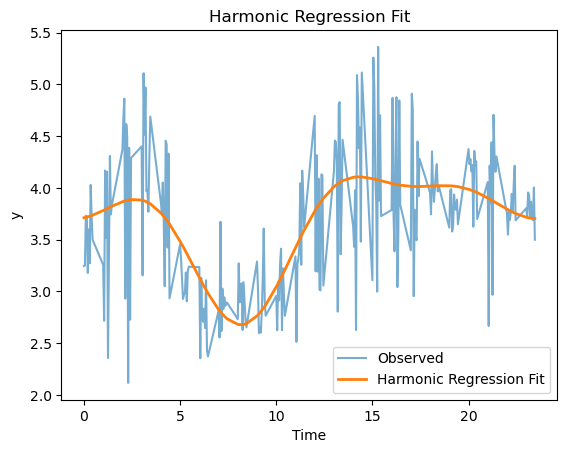

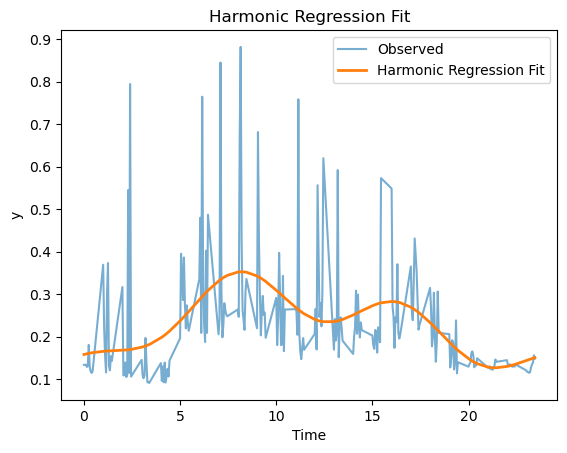

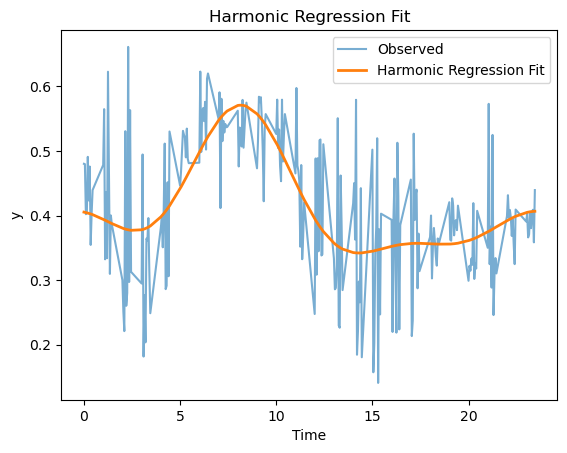

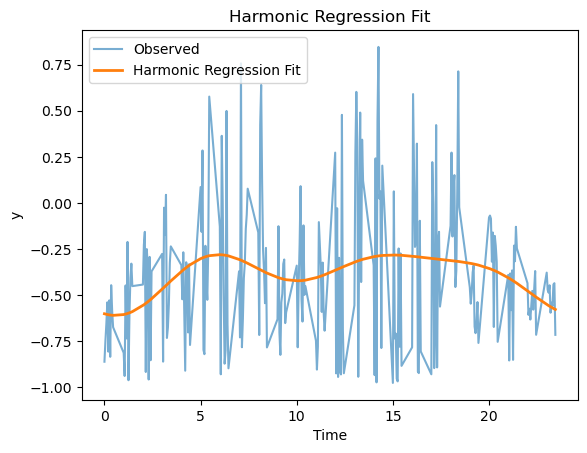

In [31]:
X = harmonic_features(data.loc[data["Date"]==19, "t"], T, K)
for i in range(len(indices)):
    y_pred = models[2][indices[i]].predict(X)
    plt.plot(data.loc[data["Date"]==19, "t"], data.loc[data["Date"]==19, indices[i]], label='Observed', alpha=0.6)
    plt.plot(data.loc[data["Date"]==19, "t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
    plt.legend()
    plt.title("Harmonic Regression Fit")
    plt.xlabel("Time")
    plt.ylabel("y")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


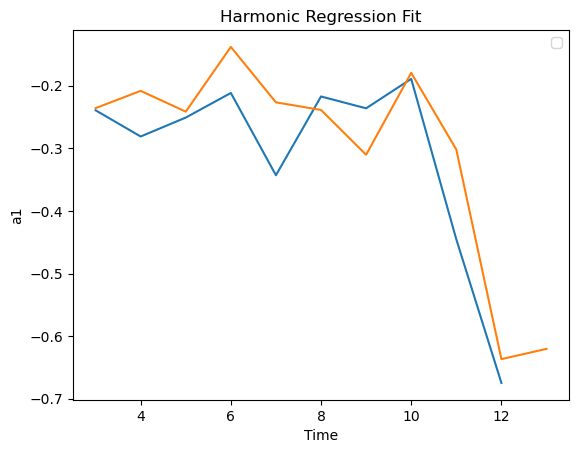

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


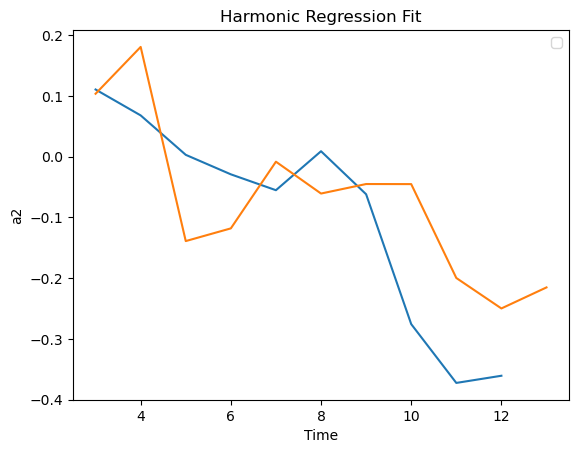

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


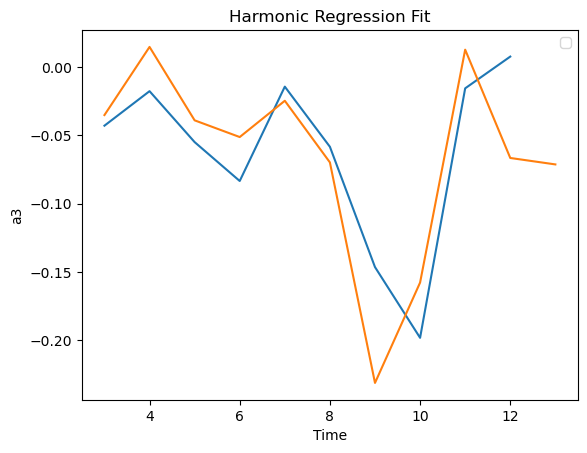

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


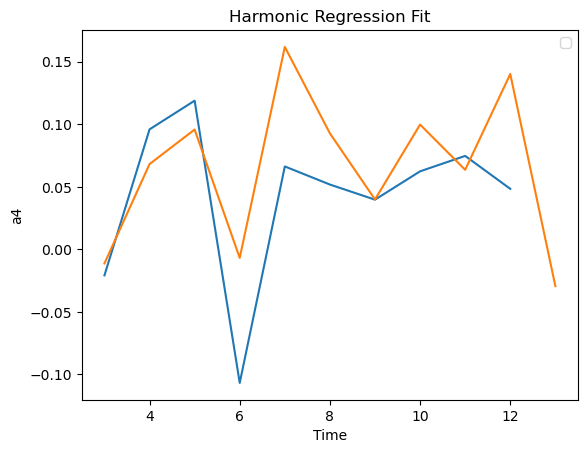

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


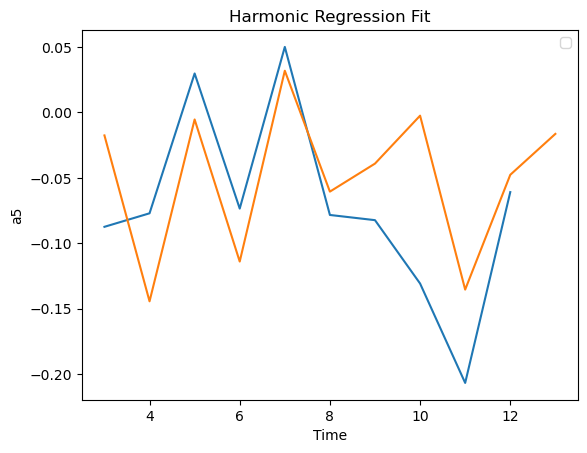

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


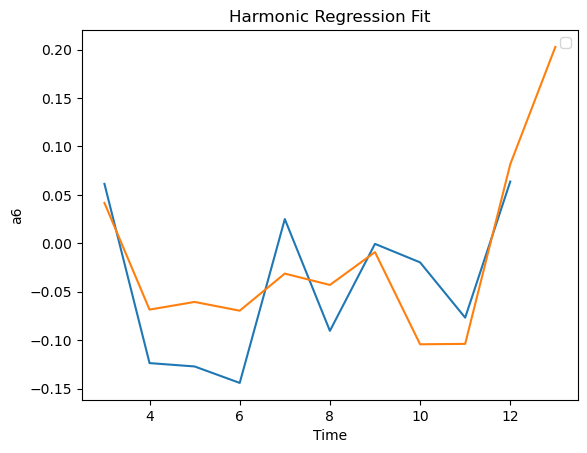

In [102]:
# for i in range(len(indices)):
for k in range(1, 7):
# plt.plot(data.loc[data["Date"]==19, "t"], data.loc[data["Date"]==19, indices[i]], label='Observed', alpha=0.6)
# plt.plot(data.loc[data["Date"]==19, "t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
    # plt.plot([coefficients1[j]["date"] for j in range(1, len(coefficients1)-1)], [coefficients1[j]['ADI']["Coefficients"][k] for j in range(1, len(coefficients1)-1)])
    
    plt.plot([coefficients2[j]["date"] for j in range(1, len(coefficients2)-1)], [coefficients2[j]['NDSI']["Coefficients"][k] for j in range(1, len(coefficients2)-1)])
    plt.plot([coefficients3[j]["date"] for j in range(1, len(coefficients3)-1)], [coefficients3[j]['NDSI']["Coefficients"][k] for j in range(1, len(coefficients3)-1)])
    plt.legend()
    plt.title("Harmonic Regression Fit")
    plt.xlabel("Time")
    plt.ylabel(f"a{k}")
    # plt.savefig(f"harmonic_regression_fit_a{k}_spot1_samegraph.png")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


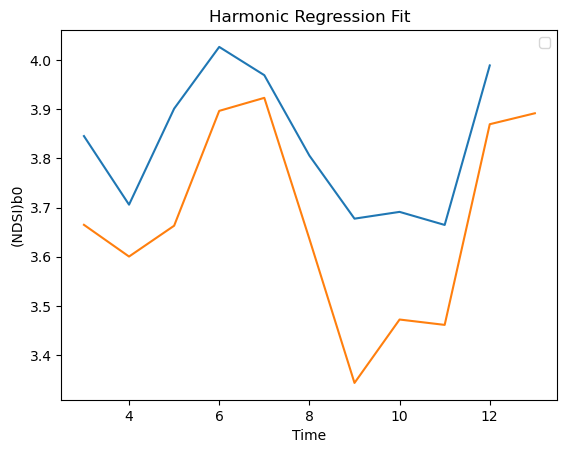

In [99]:
# for i in range(len(indices)):
    # plt.plot(data.loc[data["Date"]==19, "t"], data.loc[data["Date"]==19, indices[i]], label='Observed', alpha=0.6)
    # plt.plot(data.loc[data["Date"]==19, "t"], y_pred, label='Harmonic Regression Fit', linewidth=2)
# plt.plot([coefficients1[j]["date"] for j in range(1, len(coefficients1)-1)], [coefficients1[j]['NDSI']["Intercept"] for j in range(1, len(coefficients1)-1)])
plt.plot([coefficients2[j]["date"] for j in range(1, len(coefficients2)-1)], [coefficients2[j]['ADI']["Intercept"] for j in range(1, len(coefficients2)-1)])
plt.plot([coefficients3[j]["date"] for j in range(1, len(coefficients3)-1)], [coefficients3[j]['ADI']["Intercept"] for j in range(1, len(coefficients3)-1)])
plt.legend()
plt.title("Harmonic Regression Fit")
plt.xlabel("Time")
plt.ylabel("(NDSI)b0")
# plt.savefig("harmonic_regression_fit_b0_spot1_samegraph.png")
plt.show()

In [42]:
coefficients

[{'date': 17,
  'ADI': {'Intercept': 3.610778735290755,
   'Coefficients': array([ 0.        ,  0.58620236, -0.50823382, -0.7558591 , -0.412805  ,
          -0.70390925,  0.04310642])},
  'ACI': {'Intercept': 0.15814694835947582,
   'Coefficients': array([ 0.        , -0.02879361,  0.15396256,  0.06398883,  0.00509042,
           0.09930803, -0.00083973])},
  'AEI': {'Intercept': 0.42137513810024585,
   'Coefficients': array([ 0.        , -0.09393853,  0.08144413,  0.12112591,  0.06615172,
           0.11280098, -0.00690778])},
  'NDSI': {'Intercept': -0.6679659808368128,
   'Coefficients': array([ 0.        , -0.03899242,  0.10131679, -0.11316319, -0.02178282,
           0.00791464,  0.04224454])}},
 {'date': 18,
  'ADI': {'Intercept': 3.5957238954166666,
   'Coefficients': array([ 0.        , -0.34707314, -0.46789832,  0.14552317,  0.41877128,
          -0.17624159, -0.07361272])},
  'ACI': {'Intercept': 0.22042512722916666,
   'Coefficients': array([ 0.        , -0.09265832,  0.0306

In [46]:
data.loc[data["Date"]==29]

,Filename,Segment,Month,Date,Hour,Minute,ADI,ACI,AEI,NDSI,Year,Second,t
2800,04213SPOT1_20250529_000000.wav,1,5,29,0,0,3.518463,0.121455,0.436169,-0.789286,2025,0,0.00
2801,04213SPOT1_20250529_000000.wav,2,5,29,0,0,3.560377,0.120196,0.429452,-0.412036,2025,180,0.05
2802,04213SPOT1_20250529_000000.wav,3,5,29,0,0,4.592794,0.122335,0.264008,-0.115789,2025,360,0.10
2803,04213SPOT1_20250529_000000.wav,4,5,29,0,0,4.370858,0.110011,0.299573,-0.322556,2025,540,0.15
2804,04213SPOT1_20250529_000000.wav,5,5,29,0,0,4.790028,0.116394,0.232401,0.014021,2025,720,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,04213SPOT1_20250529_060000.wav,6,5,29,6,0,2.851465,0.162068,0.543055,-0.959193,2025,900,6.25
2866,04213SPOT1_20250529_060000.wav,7,5,29,6,0,3.220818,0.212602,0.483866,-0.870753,2025,1080,6.30
2867,04213SPOT1_20250529_060000.wav,8,5,29,6,0,3.471316,0.160437,0.443724,-0.468431,2025,1260,6.35
2868,04213SPOT1_20250529_060000.wav,9,5,29,6,0,3.250243,0.226457,0.479151,-0.248272,2025,1440,6.40


In [130]:
coef_df_3


,Index,Intercept,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7
0,ADI,3.891808,0.0,-0.105423,0.150222,0.161374,-0.219795,0.134127,0.029460
1,ACI,0.198186,0.0,0.028856,0.042768,-0.018194,-0.004401,-0.002336,0.004727
2,AEI,0.376340,0.0,0.016894,-0.024073,-0.025860,0.035222,-0.021494,-0.004721
3,NDSI,-0.368534,0.0,0.057826,0.254485,0.016806,-0.092996,0.070166,-0.103746


In [131]:
coef_df_4

,Index,Intercept,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7
0,ADI,3.839841,0.0,-0.072940,0.172176,0.050426,0.022632,-0.024629,-0.122008
1,ACI,0.238346,0.0,-0.019089,-0.085915,0.008355,-0.030601,0.011283,0.002792
2,AEI,0.384668,0.0,0.011689,-0.027591,-0.008081,-0.003627,0.003947,0.019552
3,NDSI,-0.096905,0.0,-0.201038,-0.430512,0.042146,-0.097525,-0.003920,-0.096777


In [143]:
coef_df_1

,Index,Intercept,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7
0,ADI,3.654165,0.0,-0.165135,0.191344,-0.480376,-0.135185,-0.203659,0.095356
1,ACI,0.195500,0.0,0.035550,0.050314,0.031626,-0.012527,0.009456,-0.000200
2,AEI,0.414423,0.0,0.026463,-0.030663,0.076980,0.021663,0.032636,-0.015281
3,NDSI,-0.468459,0.0,-0.013965,0.029779,-0.074976,-0.100825,-0.019106,-0.013021


In [148]:
coef_df_2

,Index,Intercept,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7
0,ADI,3.893760,0.0,-0.145059,-0.057246,0.099880,0.043991,0.129903,0.030307
1,ACI,0.181457,0.0,0.012856,-0.031238,0.010697,-0.005415,0.007036,-0.003022
2,AEI,0.376028,0.0,0.023246,0.009174,-0.016006,-0.007050,-0.020817,-0.004857
3,NDSI,-0.379889,0.0,-0.102693,-0.102290,0.025697,0.049826,-0.028449,-0.003553


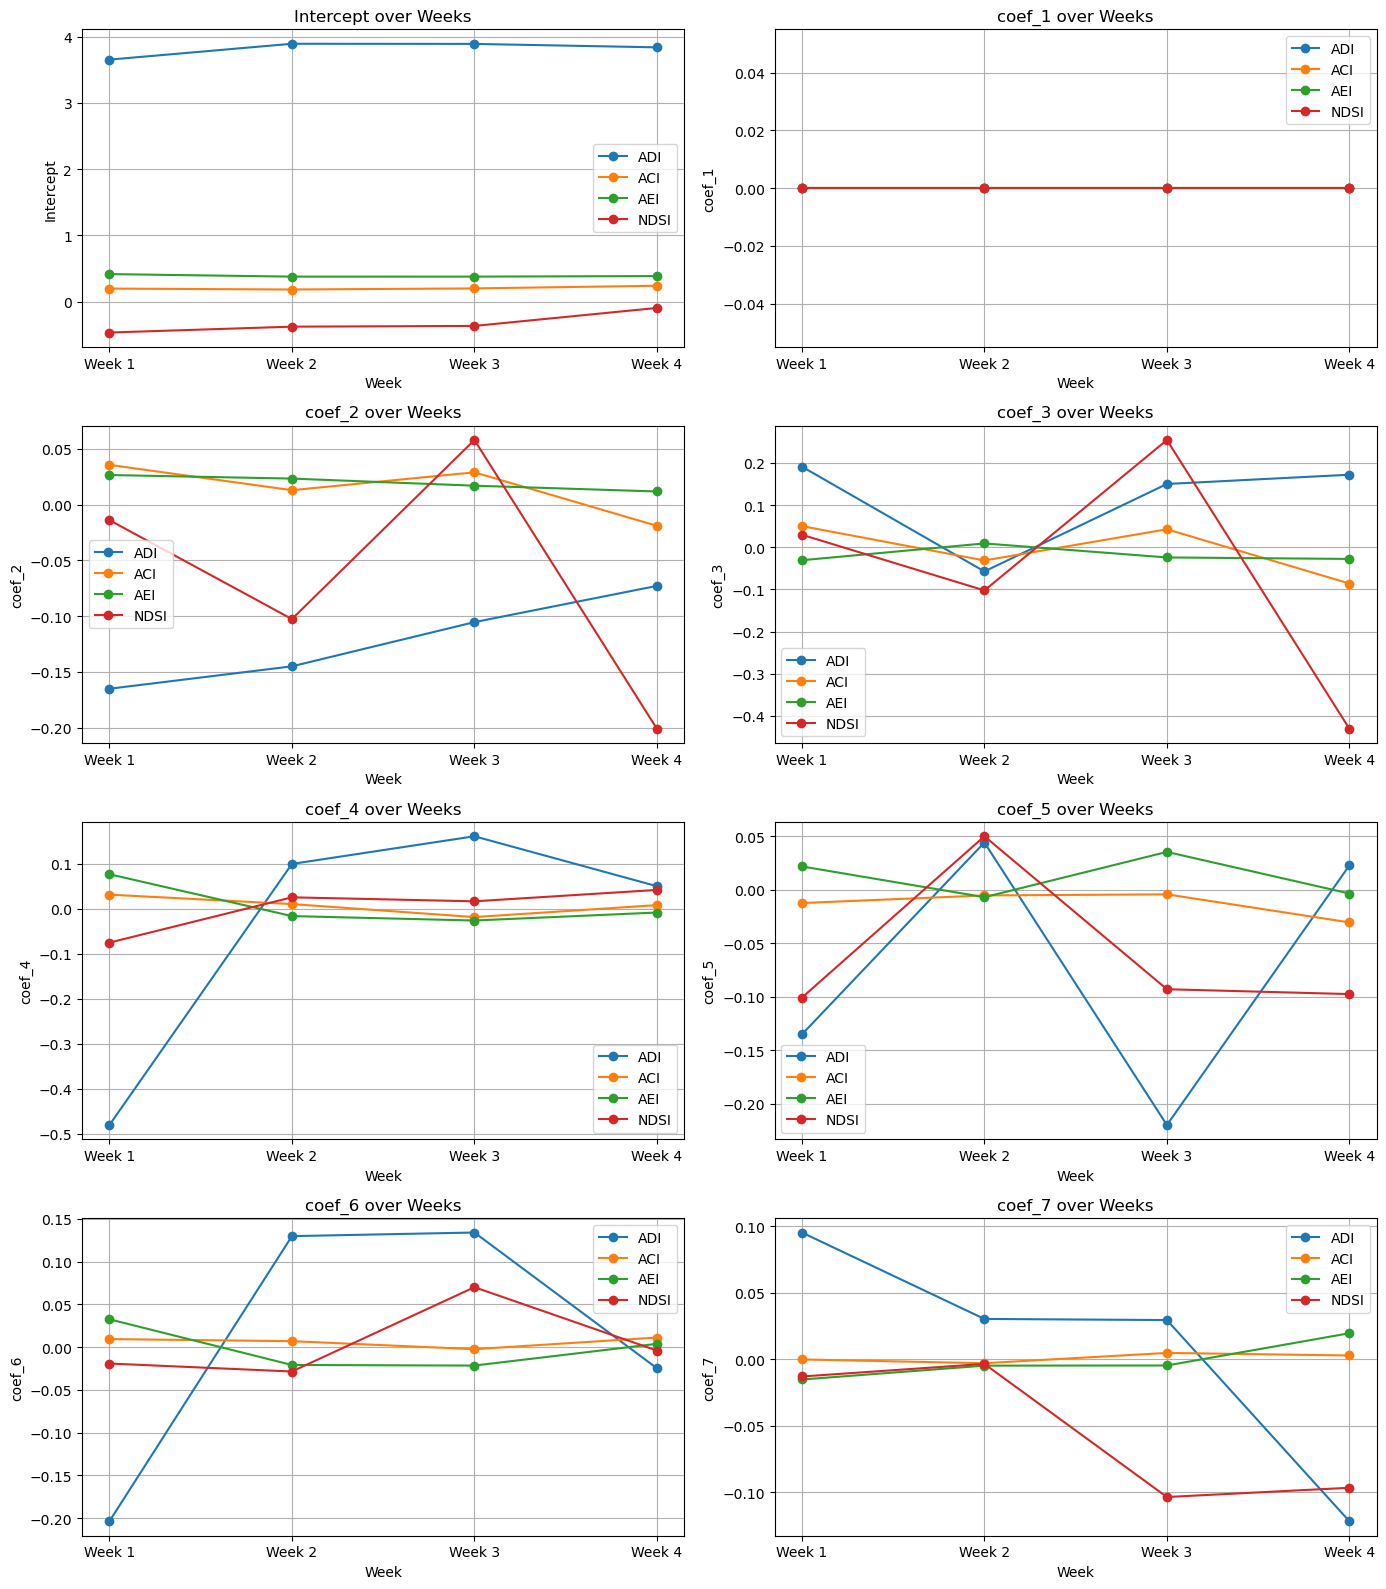

In [149]:
import matplotlib.pyplot as plt

# List of your coefficient DataFrames in week order
coefs = [coef_df_1, coef_df_2, coef_df_3, coef_df_4]

# Weeks and indices
weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4']
indices = ['ADI', 'ACI', 'AEI', 'NDSI']

# All coefficient columns to plot
coef_columns = ['Intercept', 'coef_1', 'coef_2', 'coef_3', 'coef_4', 'coef_5', 'coef_6', 'coef_7']

# Set up subplots: 4 rows x 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Plot each coefficient in its subplot
for i, coef in enumerate(coef_columns):
    ax = axes[i]
    
    for index in indices:
        values = [df.loc[df['Index'] == index, coef].values[0] for df in coefs]
        ax.plot(weeks, values, marker='o', label=index)
    
    ax.set_title(f'{coef} over Weeks')
    ax.set_xlabel('Week')
    ax.set_ylabel(coef)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
